# Bibliotécas

In [1]:
import pandas                                                 as pd
import numpy                                                  as np
import seaborn                                                as sns
import matplotlib                                             as mpl 
from sklearn                 import model_selection           as ms
from matplotlib              import pyplot                    as plt
from sklearn                 import linear_model              as lm
from sklearn                 import metrics                   as mt
from sklearn                 import preprocessing             as pp
from statsmodels             import api                       as sm
from sklearn.ensemble        import GradientBoostingRegressor as gbr
from matplotlib.gridspec     import GridSpec
from sklearn.linear_model    import Lasso, Ridge
from skopt                   import BayesSearchCV
from skopt.space             import Real, Categorical, Integer
from sklearn.svm             import SVR
from sklearn.dummy           import DummyRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble        import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics         import make_scorer, mean_absolute_error, mean_squared_error
from IPython.display         import HTML
from ydata_profiling         import ProfileReport
from google.cloud            import storage
import pickle
import inflection
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 12

#Configurando as paleta de cores
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

#Cores utilizadas
#sns.color_palette(color_palette)

# Funções

In [2]:
#from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container{width: 100% !important;}</style>'))
    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

#import inflection
def renomear_colunas(df):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def descricao_estatistica_variaveis_numericas(df):
    #Métricas de tendência central: média e mediana
    central_1 = pd.DataFrame(df.apply(np.mean)).T
    central_2 = pd.DataFrame(df.apply(np.median)).T
    
    #Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
    dispersao_1 = pd.DataFrame(df.apply(np.std)).T
    dispersao_2 = pd.DataFrame(df.apply(np.min)).T
    dispersao_3 = pd.DataFrame(df.apply(np.max)).T
    dispersao_4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    dispersao_5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    dispersao_6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T
    
    metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
    metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
    return metricas

def descricao_estatistica_variaveis_categoricas(df):
    return df.apply(lambda x: x.unique().shape[0])

def converter_para_int(dataframe: pd.DataFrame, nome_coluna: str) -> bool:
    """
    Descrição:
        Converter a coluna especificada em um dataframe para tipo inteiro
    
    Argumentos:
        dataframe (pd.DataFrame): O dataframe a ser processado
        nome_coluna (str): O nome da coluna a ser convertida
    
    Returns:
        booleano: True se a conversão foi bem sucedida
    """
    try:
        dataframe[nome_coluna] = dataframe[nome_coluna].astype(int)
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo inteiro.")
        return False

def converter_para_data(dataframe: pd.DataFrame, nome_coluna: str, formato_data: str = None) -> bool:
    """
    Descrição:
        Converter a coluna especificada em um dataframe para tipo data
    
    Argumentos:
        dataframe (pd.DataFrame): O dataframe a ser processado
        nome_coluna (str): O nome da coluna a ser convertida
    
    Returns:
        booleano: True se a conversão foi bem sucedida
    """
    try:
        dataframe[nome_coluna] = pd.to_datetime(dataframe[nome_coluna])
        return True
    except ValueError:
        print(f"Erro: Não foi possível converter a coluna '{nome_coluna}' para tipo de data.")
        return False

    #from sklearn.model_selection import KFold
#from sklearn.metrics import mean_absolute_error, mean_squared_error    
def ml_error(y, y_pred, desvpad = True):
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y))
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    std_mae = np.std(np.abs(y - y_pred))
    std_mape = np.std(np.abs((y - y_pred) / y))
    std_rmse = np.std(np.abs(y - y_pred))    
    if desvpad:
        return pd.DataFrame({'mae': f"{mae:.2f} +/- {std_mae:.2f}", 
                             'mape': f"{mape:.2f} +/- {std_mape:.2f}",
                             'rmse': f"{rmse:.2f} +/- {std_rmse:.2f}"}, index = [0])
    else:
        return pd.DataFrame({'mae': f"{mae:.2f}",
                             'mape': f"{mape:.2f}",
                             'rmse': f"{rmse:.2f}"}, index = [0])

def validacao_cruzada(modelo, x, y, desvpad = True, verbose = True):
    kfold = KFold(n_splits=5)
    
    resultados = []

    for idx, (treino_idx, validacao_idx) in enumerate(kfold.split(x, y)):
        
        if verbose:
            linha_inicial = validacao_idx[0]
            linha_final = validacao_idx[-1]
            print(f"Fold {idx}: {linha_inicial} - {linha_final}")
        
        if isinstance(x, np.ndarray):
            x_treino_fold, x_validacao_fold = x[treino_idx], x[validacao_idx]
        else:
            x_treino_fold, x_validacao_fold = x.iloc[treino_idx], x.iloc[validacao_idx]

        if isinstance(y, np.ndarray):
            y_treino_fold, y_validacao_fold = y[treino_idx], y[validacao_idx]
        else:
            y_treino_fold, y_validacao_fold = y.iloc[treino_idx], y.iloc[validacao_idx]

        modelo.fit(x_treino_fold, y_treino_fold)
        y_pred = modelo.predict(x_validacao_fold)

        mae = mean_absolute_error(np.expm1(y_validacao_fold), np.expm1(y_pred))
        mape = np.mean(np.abs((np.expm1(y_validacao_fold) - np.expm1(y_pred)) / np.expm1(y_validacao_fold)))
        rmse = np.sqrt(mean_squared_error(np.expm1(y_validacao_fold), np.expm1(y_pred)))
        std_mae = np.std(np.abs(np.expm1(y_validacao_fold) - np.expm1(y_pred)))
        std_mape = np.std(np.abs((np.expm1(y_validacao_fold) - np.expm1(y_pred)) / np.expm1(y_validacao_fold)))
        std_rmse = np.std(np.abs(np.expm1(y_validacao_fold) - np.expm1(y_pred)))    
        
        resultado = {'mae': mae, 
                     'mape': mape,
                     'rmse': rmse,
                     'std_mae': std_mae,
                     'std_mape': std_mape,
                     'std_rmse': std_rmse}
        
        resultados.append(resultado)

    # Calculando a média e o desvio padrão para cada métrica em todos os folds
    mean_resultados = {metrica: np.mean([r[metrica] for r in resultados]) for metrica in resultados[0]}
    std_resultados = {metrica: np.std([r[metrica] for r in resultados]) for metrica in resultados[0]}
    
    if desvpad:
        return pd.DataFrame({'algoritmo': modelo.__class__.__name__,
                             'mae_cv': f"{mean_resultados['mae']:.2f} +/- {std_resultados['std_mae']:.2f}",
                             'mape_cv': f"{mean_resultados['mape']:.2f} +/- {std_resultados['std_mape']:.2f}",
                             'rmse_cv': f"{mean_resultados['rmse']:.2f} +/- {std_resultados['std_rmse']:.2f}"}, index = [0])
    else:
        return pd.DataFrame({'algoritmo': modelo.__class__.__name__,
                             'mae_cv': f"{mean_resultados['mae']:.2f}",
                             'mape_cv': f"{mean_resultados['mape']:.2f}",
                             'rmse_cv': f"{mean_resultados['rmse']:.2f}"}, index = [0])

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.1 Descrição do desafio

#### Você recebeu uma tarefa de criar um modelo de machine learning para auxiliar uma construtora a medir a resistência do concreto,
#### pois eles dependem dessa questão para construir os seus projetos, e a equipe de engenheiros está interessada em prever a
#### resistência do concreto, que é a parte mais importante da constução civil, dado algumas características que eles têm disponíveis. 

#### 1.7.1 Descrição das colunas

**Cement (Cimento):** O cimento é um dos principais componentes do concreto. Ele é responsável por ligar os outros materiais, como agregados, e formar uma massa coesa. O tipo e a quantidade de cimento utilizados podem influenciar significativamente a resistência do concreto.

**Slag (Escarpa):** Slag, ou escarpa, é um subproduto da produção de aço, frequentemente usado como componente do cimento ou como adição ao concreto. Sua presença pode afetar propriedades como resistência e durabilidade.

**Flyash (Cinzas volantes):** Cinzas volantes são subprodutos resultantes da queima de carvão em usinas termoelétricas. Elas podem ser usadas como adição ao cimento ou ao concreto, proporcionando benefícios como melhoria da trabalhabilidade, redução do calor de hidratação e aumento da durabilidade.

**Water (Água):** A água é um componente essencial do concreto, pois é necessária para a hidratação do cimento, que é o processo pelo qual o cimento reage quimicamente e endurece. A quantidade de água utilizada afeta a trabalhabilidade e a resistência do concreto.

**Superplasticizer (Superplastificante):** Superplastificantes são aditivos químicos adicionados ao concreto para melhorar sua trabalhabilidade sem aumentar significativamente a quantidade de água. Eles permitem a redução da relação água/cimento, o que pode resultar em concretos mais resistentes e duráveis.

**Coarse Aggregate (Agregado graúdo):** Os agregados graúdos são partículas de materiais como pedra britada, cascalho ou pedregulho, que são adicionados ao concreto para aumentar sua resistência. Eles fornecem suporte estrutural e ajudam a reduzir a quantidade de pasta de cimento necessária.

**Fine Aggregate (Agregado fino):** Os agregados finos são partículas de materiais como areia ou pó de pedra, que são adicionados ao concreto para preencher os espaços entre os agregados graúdos e melhorar a trabalhabilidade.

**Age (Idade em dias):** A idade do concreto se refere ao tempo decorrido desde sua mistura inicial até o momento da avaliação. A idade do concreto pode afetar sua resistência e outras propriedades, uma vez que o processo de cura e endurecimento continua ao longo do tempo.

**csMPa (Resistência Compressiva em Megapascal):** Este é o atributo alvo que o modelo de previsão deve estimar. Representa a resistência do concreto à compressão, medida em megapascal (MPa). É uma medida crítica da qualidade e da adequação do concreto para determinadas aplicações na construção civil.

### 1.2 Carregar os dados

In [3]:
df_raw = pd.read_csv('../dataset/dados.csv')

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### 1.2.1 Separar em treino e teste

In [6]:
x = df1.drop('csMPa', axis = 1)
y = df1['csMPa'].copy()

x_treino, x_teste, y_treino, y_teste = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

df1 = pd.concat([x_treino, y_treino], axis = 1)

In [7]:
print('x_treino: {}'.format(x_treino.shape))
print('x_teste: {}'.format(x_teste.shape))
print('\ny_treino: {}'.format(y_treino.shape))
print('y_teste: {}'.format(y_teste.shape))

x_treino: (824, 8)
x_teste: (206, 8)

y_treino: (824,)
y_teste: (206,)


* Separando os dados em treino e teste, este processo envolve a alocação de uma parte dos dados disponíveis para treinar o modelo (conjunto de treinamento) e uma parte separada para avaliar sua qualidade (conjunto de teste). Os dados de teste representam informações que o modelo nunca teve acesso durante o treinamento. Isso é essencial para avaliar a capacidade de generalização do modelo para novos dados não vistos anteriormente.
Uma razão importante para essa divisão é evitar o que é conhecido como 'data leakage' (vazamento de dados). Isso ocorre quando informações do conjunto de teste são inadvertidamente incorporadas ao conjunto de treinamento durante o processo de modelagem. Esse vazamento pode resultar em uma performance artificialmente alta nos dados de treinamento, pois o modelo pode estar se ajustando a informações que não devia conhecer. No entanto, essa performance inflada geralmente não se traduz em uma boa capacidade de generalização do modelo para dados novos e não vistos, como os do conjunto de teste.

### 1.3 Dimensão dos dados

In [8]:
df1.shape

(824, 9)

In [9]:
df1.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
995,158.6,148.9,116.0,175.1,15.0,953.3,719.7,28,27.68
507,424.0,22.0,132.0,178.0,8.5,822.0,750.0,28,62.05
334,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,3,23.80
848,252.0,97.0,76.0,194.0,8.0,835.0,821.0,28,33.40
294,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,3,7.40


In [10]:
x_teste.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7
136,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3
918,145.0,0.0,179.0,202.0,8.0,824.0,869.0,28


### <s>1.4 Editar as colunas</s>

### 1.5 Tipo de dados

In [11]:
df1.dtypes

cement              float64
slag                float64
flyash              float64
water               float64
superplasticizer    float64
coarseaggregate     float64
fineaggregate       float64
age                   int64
csMPa               float64
dtype: object

#### <s>1.5.1 Editar os tipos de dados</s>

### 1.6 Verificar NA's

In [12]:
df1.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

#### <s>1.6.1 Tratar NA's</s>

#### <s>1.6.2 Verificar NA's novamente</s>

### 1.7 Descrição estatística do negócio

In [13]:
descricao_estatistica_variaveis_numericas(df1)

,min,max,amplitude,mean,median,std,assimetria,kurtosis
cement,102.00,540.0,438.00,283.360801,275.10,107.471131,0.493343,-0.607776
slag,0.00,359.4,359.40,74.371602,22.00,86.924991,0.802065,-0.518297
flyash,0.00,195.0,195.00,53.160801,0.00,63.961799,0.566038,-1.321914
water,121.80,247.0,125.20,181.797087,185.35,21.308963,0.091973,0.176576
superplasticizer,0.00,32.2,32.20,6.163956,6.10,5.963636,0.897750,1.265712
coarseaggregate,801.00,1145.0,344.00,973.548544,968.00,78.646864,-0.041485,-0.643868
fineaggregate,594.00,992.6,398.60,772.107403,778.50,80.935561,-0.239988,-0.134458
age,1.00,365.0,364.00,44.661408,28.00,60.438994,3.335411,13.075495
csMPa,2.33,82.6,80.27,35.857864,34.08,16.854863,0.461933,-0.273861


* As medidas estatísticas ajudam a entender a distribuição, a tendência central e a dispersão dos dados, fornecendo uma informação inicial a cerca dos dados estudados, as principais são:

**Mínimo (Min):** Ajuda a entender o limite inferior dos dados;

**Máximo (Máx):** Indica o limite superior dos dados;

**Amplitude:** Diferença entre o valor máximo e mínimo. Fornece uma ideia da dispersão total dos dados;

**Média:** Oferece uma medida do valor central dos dados;

**Mediana:** É uma medida de posição que não é influenciada por valores extremos e fornece uma visão robusta da tendência central dos dados;

**Desvio Padrão:** Um desvio padrão maior indica uma maior dispersão dos dados em relação à média;

**Assimetria:** Uma distribuição simétrica terá uma assimetria próxima de zero. Uma assimetria positiva indica uma cauda mais longa à direita da distribuição, enquanto uma assimetria negativa indica uma cauda mais longa à esquerda;

**Curtose:** Refere-se à forma da distribuição dos dados em relação a seu pico. Uma curtose alta indica uma distribuição mais concentrada ao redor da média, com caudas mais pesadas, enquanto uma curtose baixa indica uma distribuição mais plana e com caudas mais leves.

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis

In [14]:
df2 = df1.copy()

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)

In [15]:
df3 = df2.copy()

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados

In [16]:
df4 = df3.copy()

### 4.1 Análise univariada

#### 4.1.1 Variável resposta

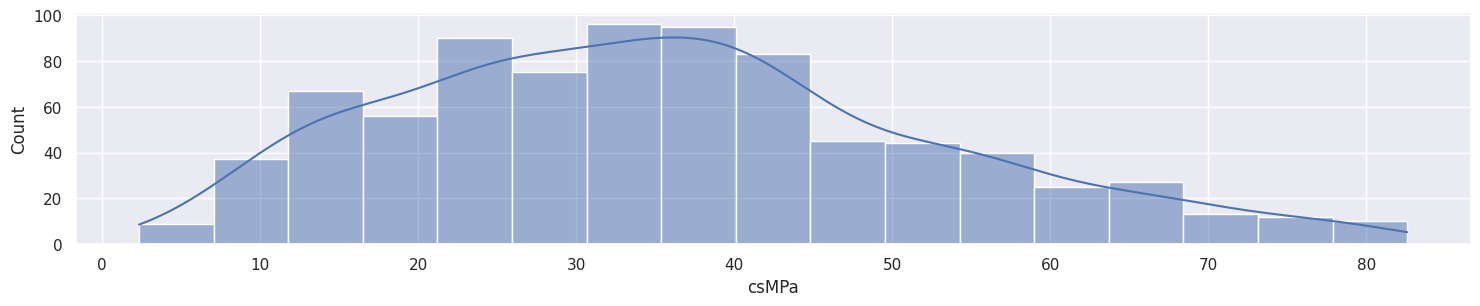

In [17]:
plt.figure(figsize = (18, 3)) #Ajuste o tamanho conforme necessário

#csMPa
sns.histplot(x = 'csMPa', data = df4, kde = True);

* Na análise univariada, busca-se avaliar o comportamento da variável resposta. Neste caso, a variável resposta exibe uma distribuição 'quase' normal, o que significa que os dados estão principalmente concentrados na porção inferior a 40 no histograma. Isso sugere que a maioria dos dados está agrupada antes desta faixa específica, indicando uma tendência central na distribuição dos dados.

#### 4.1.2 Outras variáveis

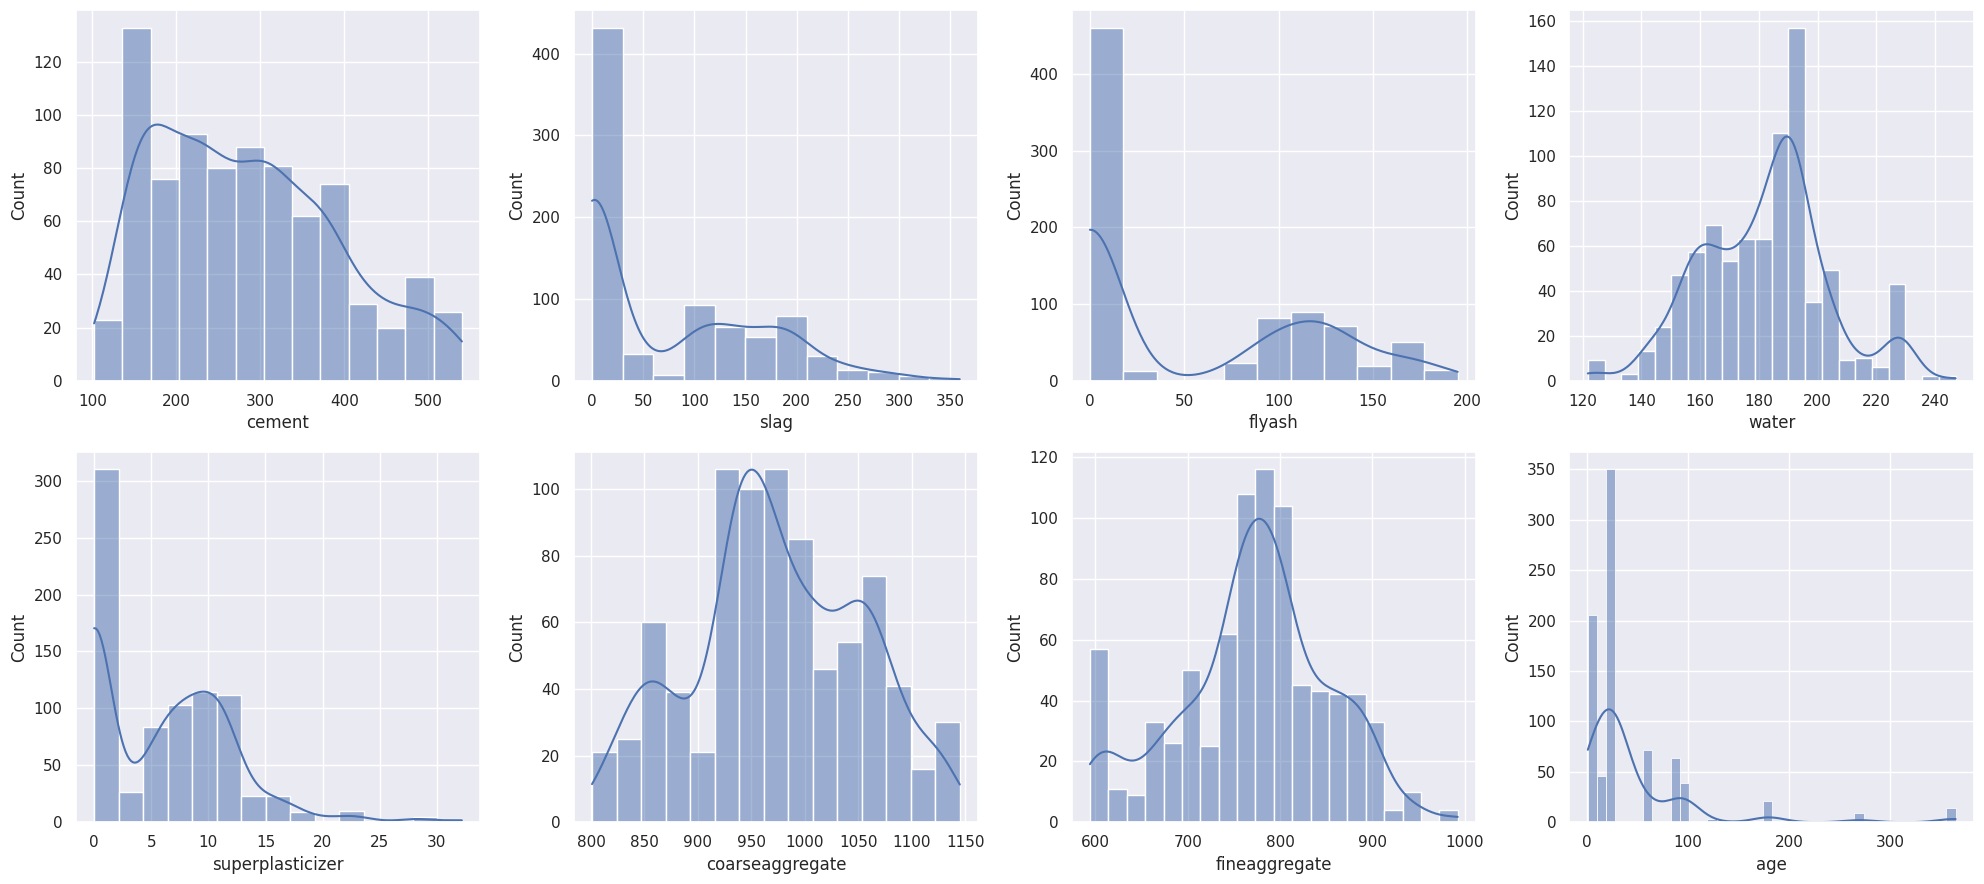

In [18]:
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#cement
plt.subplot(grid[0, 0])
sns.histplot(x = 'cement', data = df4, kde = True)

#slag
plt.subplot(grid[0, 1])
sns.histplot(x = 'slag', data = df4, kde = True)

#flyash
plt.subplot(grid[0, 2])
sns.histplot(x = 'flyash', data = df4, kde = True)

#water
plt.subplot(grid[0, 3])
sns.histplot(x = 'water', data = df4, kde = True)

#superplasticizer
plt.subplot(grid[1, 0])
sns.histplot(x = 'superplasticizer', data = df4, kde = True)

#coarseaggregate
plt.subplot(grid[1, 1])
sns.histplot(x = 'coarseaggregate', data = df4, kde = True)

#fineaggregate
plt.subplot(grid[1, 2])
sns.histplot(x = 'fineaggregate', data = df4, kde = True)

#age
plt.subplot(grid[1, 3])
sns.histplot(x = 'age', data = df4, kde = True)

plt.tight_layout();

* É possivel identificar que cada variável não segue uma distribuição normal, pode ser indicativo da necessidade de transformações nos dados para melhorar sua adequação aos modelos estatísticos.

#### 4.1.3 Verificar se existem outliers

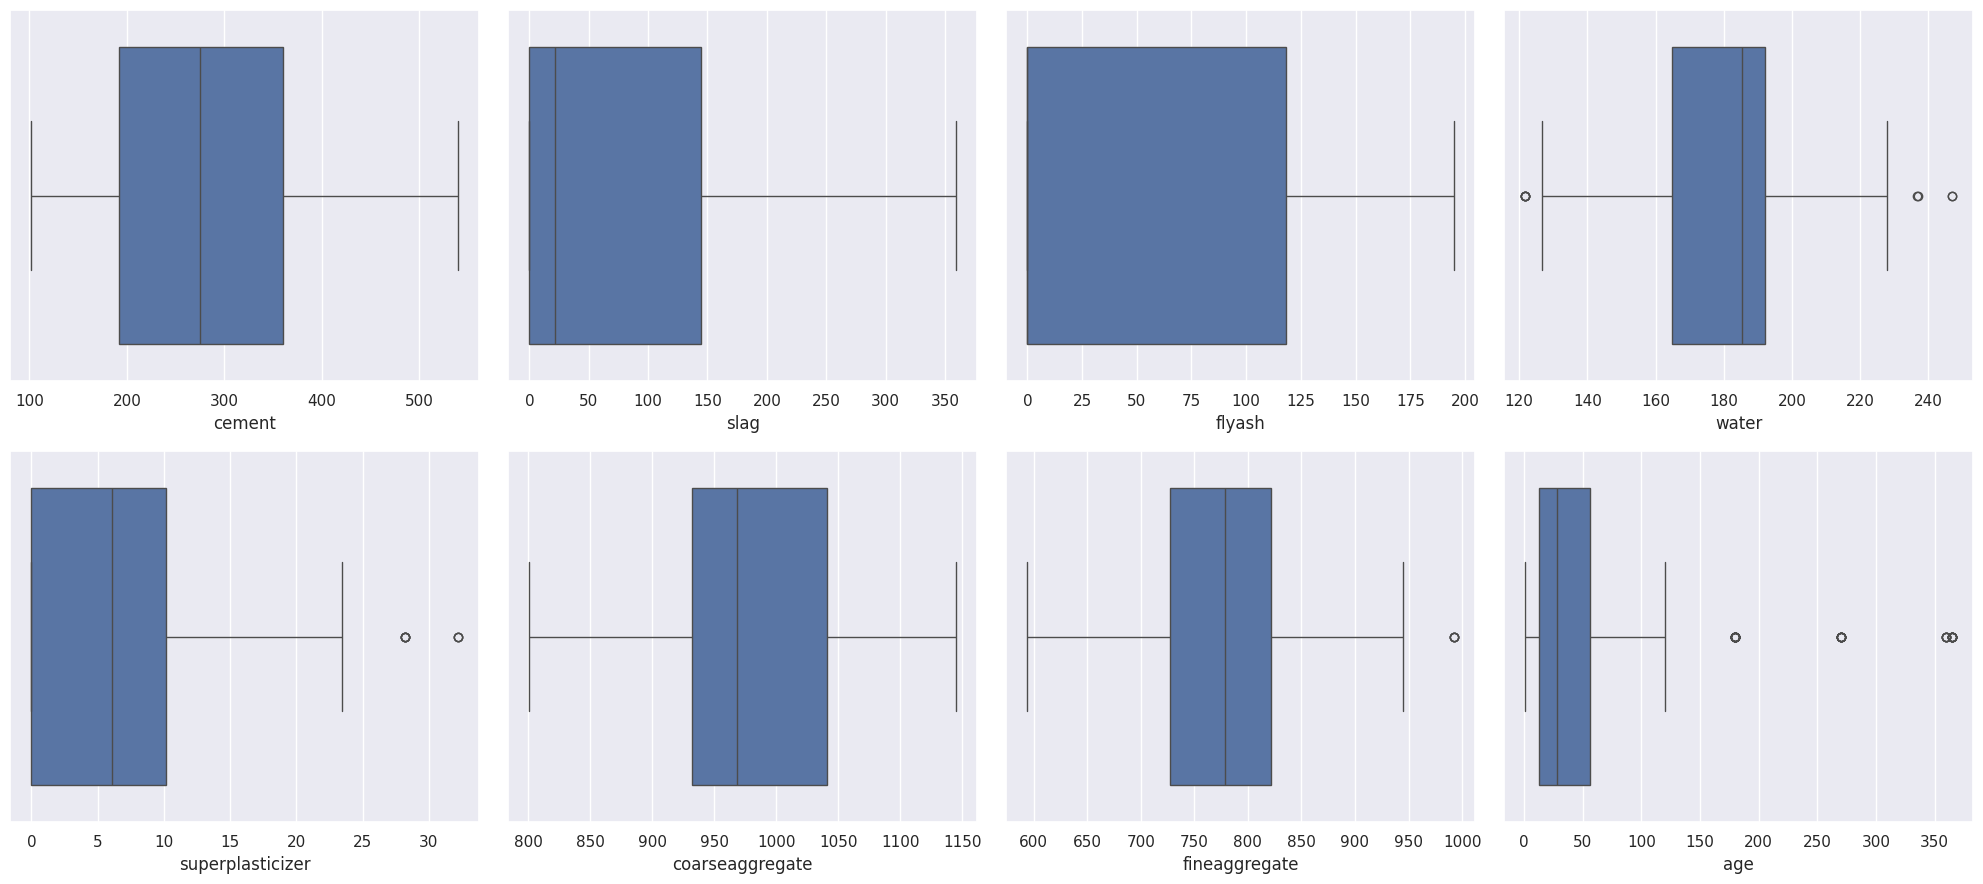

In [19]:
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#cement
plt.subplot(grid[0, 0])
sns.boxplot(x = 'cement', data = df4)

#slag
plt.subplot(grid[0, 1])
sns.boxplot(x = 'slag', data = df4)

#flyash
plt.subplot(grid[0, 2])
sns.boxplot(x = 'flyash', data = df4)

#water
plt.subplot(grid[0, 3])
sns.boxplot(x = 'water', data = df4)

#superplasticizer
plt.subplot(grid[1, 0])
sns.boxplot(x = 'superplasticizer', data = df4)

#coarseaggregate
plt.subplot(grid[1, 1])
sns.boxplot(x = 'coarseaggregate', data = df4)

#fineaggregate
plt.subplot(grid[1, 2])
sns.boxplot(x = 'fineaggregate', data = df4)

#age
plt.subplot(grid[1, 3])
sns.boxplot(x = 'age', data = df4)

plt.tight_layout();

* A variável que possui mais outliers é a 'age', contudo as variáveis 'superplasticizer' e 'water' também mostram que possuem valores atípicos
Outliers são pontos de dados que se afastam significativamente do padrão geral de distribuição de uma variável. Eles podem ser causados por erros de medição, falhas nos processos de coleta de dados ou representar eventos raros e extremos. A presença de outliers pode distorcer a análises estatísticas e modelos, afetando negativamente sua precisão e interpretação.
No entanto, em alguns casos, outliers podem conter informações valiosas sobre o sistema ou fenômeno em estudo.

#### 4.1.4 Verificar se as distribuições são normais

### 4.2 Análise bivariada

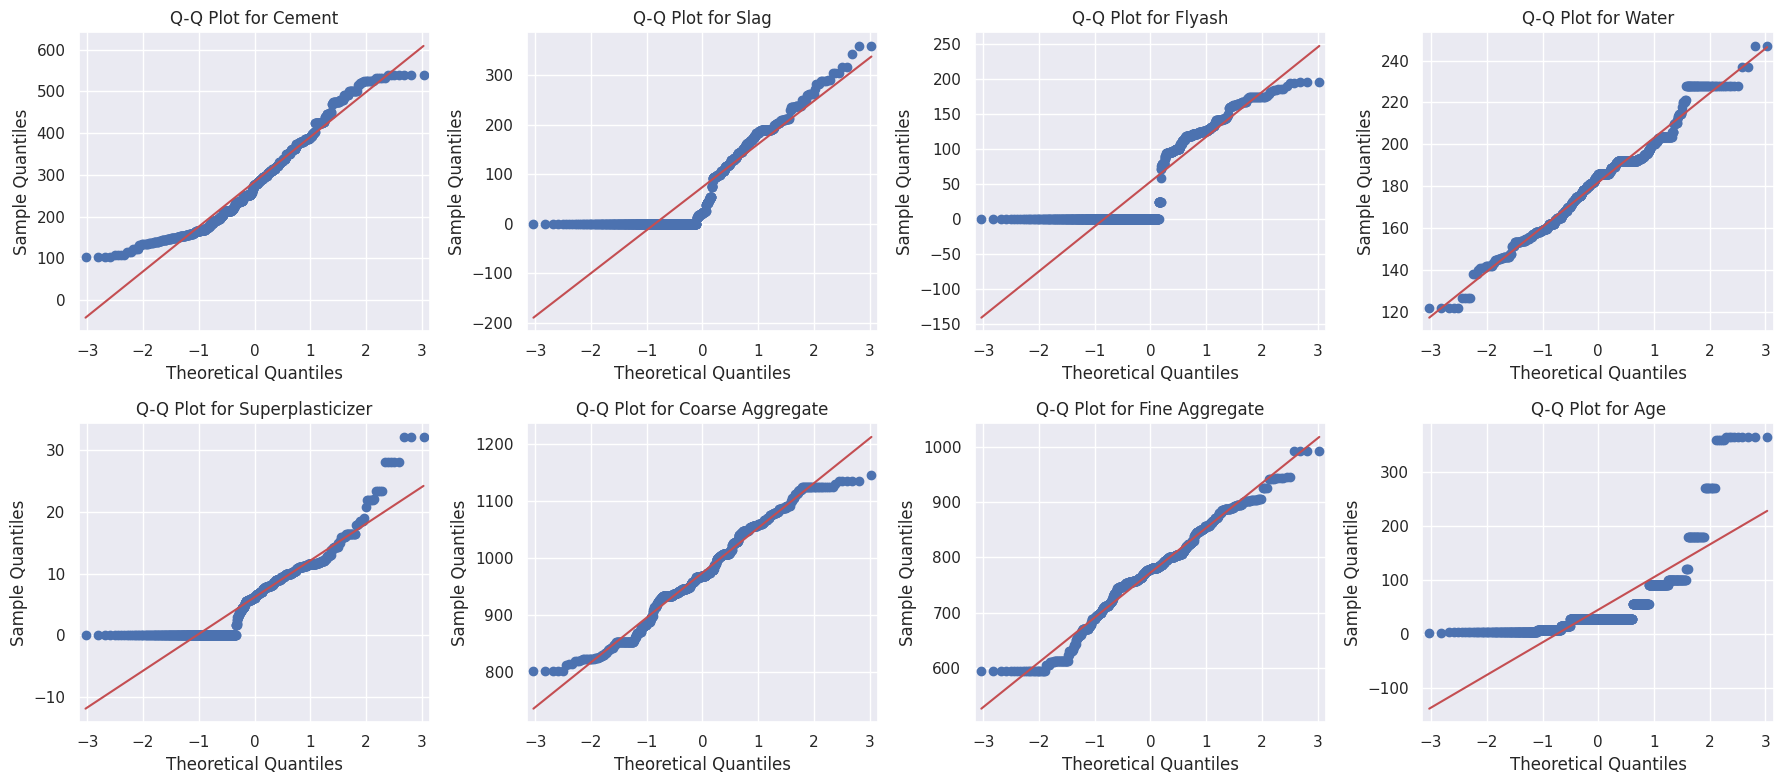

In [20]:
fig, axs = plt.subplots(2, 4, figsize = (18, 8))
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#cement
axs[0, 0].set_title('Q-Q Plot for Cement')
sm.qqplot(df4['cement'], line='s', ax=axs[0, 0])

#slag
axs[0, 1].set_title('Q-Q Plot for Slag')
sm.qqplot(df4['slag'], line='s', ax=axs[0, 1])

#flyash
axs[0, 2].set_title('Q-Q Plot for Flyash')
sm.qqplot(df4['flyash'], line='s', ax=axs[0, 2])

#water
axs[0, 3].set_title('Q-Q Plot for Water')
sm.qqplot(df4['water'], line='s', ax=axs[0, 3])

#superplasticizer
axs[1, 0].set_title('Q-Q Plot for Superplasticizer')
sm.qqplot(df4['superplasticizer'], line='s', ax=axs[1, 0])

#coarseaggregate
axs[1, 1].set_title('Q-Q Plot for Coarse Aggregate')
sm.qqplot(df4['coarseaggregate'], line='s', ax=axs[1, 1])

#fineaggregate
axs[1, 2].set_title('Q-Q Plot for Fine Aggregate')
sm.qqplot(df4['fineaggregate'], line='s', ax=axs[1, 2])

#age
axs[1, 3].set_title('Q-Q Plot for Age')
sm.qqplot(df4['age'], line='s', ax=axs[1, 3])

plt.tight_layout()
plt.show();

* O Q-Q Plot (Quantile-Quantile Plot) é uma técnica visual utilizada para verificar se uma distribuição de dados está próxima de uma distribuição normal. Ele compara os quantis (percentis) dos dados observados com os quantis esperados de uma distribuição normal teórica. Ou seja, se os dados estiverem em sua maioria na linha vermelha, os dados apresentam uma distriuição Gausiana, isso pode ser um indicativo de que os dados precisarão passar por alguma transformação para melhor se adequar a uma distribuição normal.

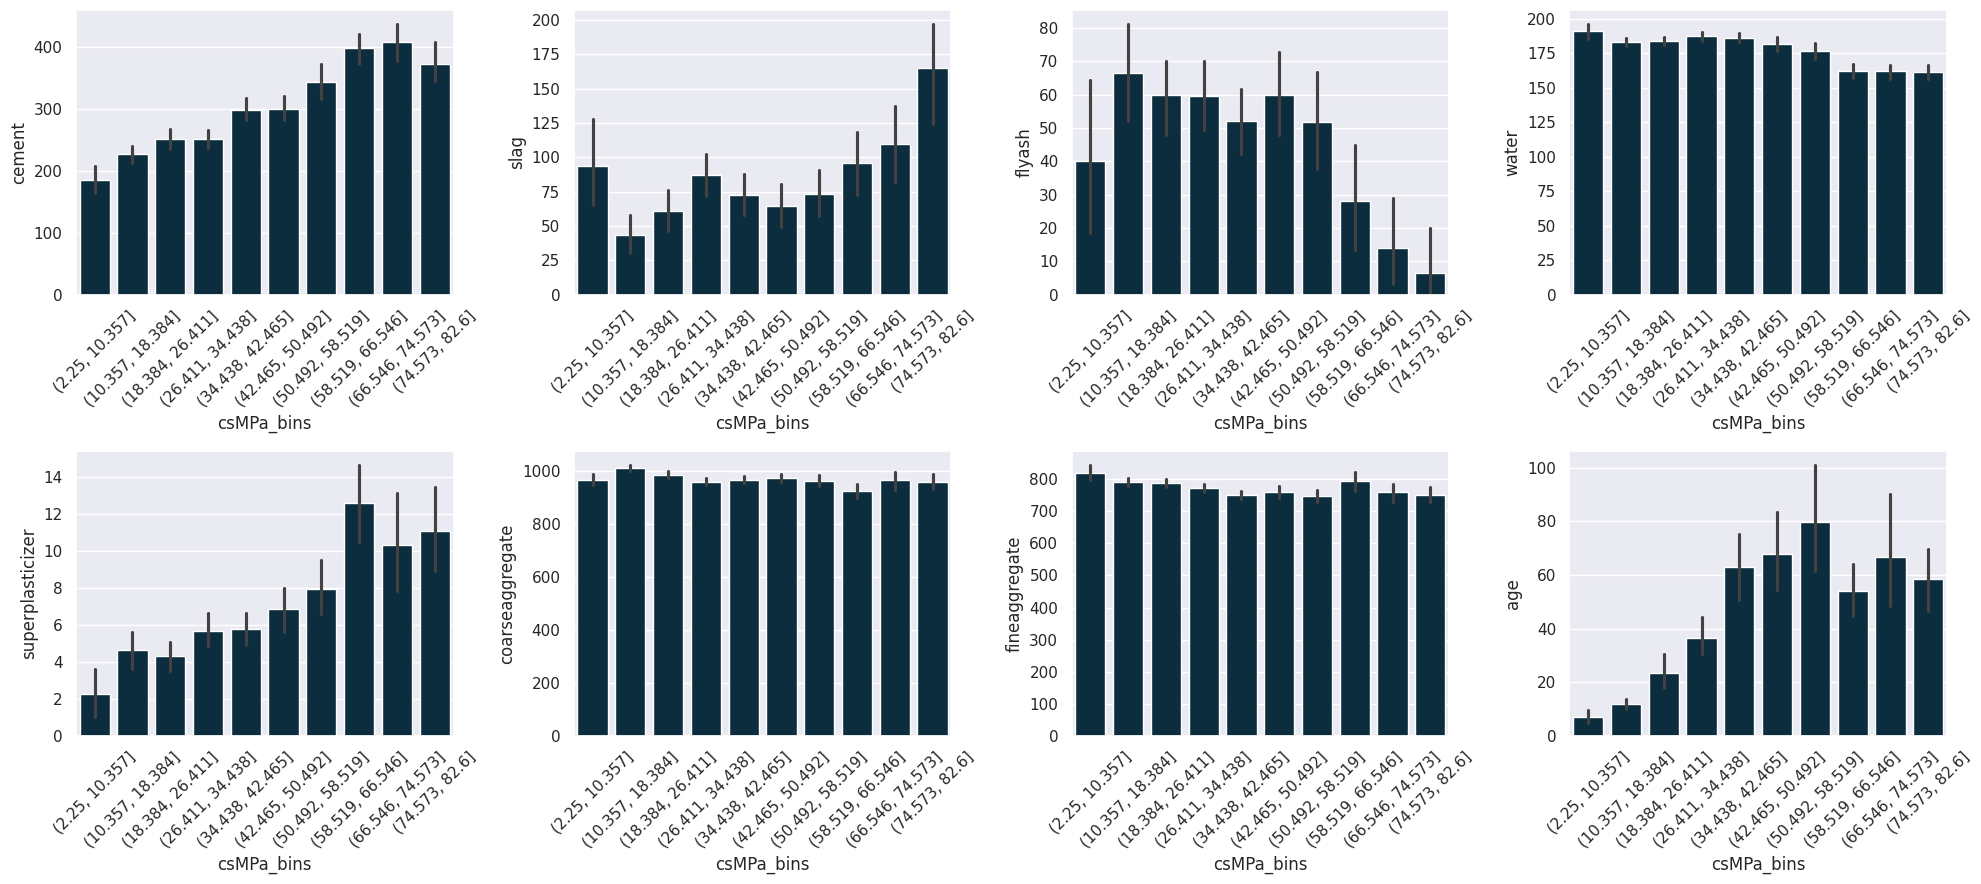

In [21]:
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

# Definindo a paleta de cores
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

aux = df4.copy()

# Dividindo os dados em 5 bins
aux['csMPa_bins'] = pd.cut(df4['csMPa'], bins = 10)

#cement
plt.subplot(grid[0, 0])
sns.barplot(x = 'csMPa_bins', y = 'cement', data = aux)
plt.xticks(rotation = 45)

#slag
plt.subplot(grid[0, 1])
sns.barplot(x = 'csMPa_bins', y = 'slag', data = aux)
plt.xticks(rotation = 45)

#flyash
plt.subplot(grid[0, 2])
sns.barplot(x = 'csMPa_bins', y = 'flyash', data = aux)
plt.xticks(rotation = 45)

#water
plt.subplot(grid[0, 3])
sns.barplot(x = 'csMPa_bins', y = 'water', data = aux)
plt.xticks(rotation = 45)

#superplasticizer
plt.subplot(grid[1, 0])
sns.barplot(x = 'csMPa_bins', y = 'superplasticizer', data = aux)
plt.xticks(rotation = 45)

#coarseaggregate
plt.subplot(grid[1, 1])
sns.barplot(x = 'csMPa_bins', y = 'coarseaggregate', data = aux)
plt.xticks(rotation = 45)

#fineaggregate
plt.subplot(grid[1, 2])
sns.barplot(x = 'csMPa_bins', y = 'fineaggregate', data = aux)
plt.xticks(rotation = 45)

#age
plt.subplot(grid[1, 3])
sns.barplot(x = 'csMPa_bins', y = 'age', data = aux)
plt.xticks(rotation = 45)

plt.tight_layout();


* O gráfico de barras que compara a variável resposta com as demais variáveis independentes ajuda a visualizar como a variável alvo varia em relação às diferentes categorias das variáveis independentes. Essa análise é útil para identificar padrões, tendências e relações entre as variáveis. No entanto, observa-se que as variáveis 'water', 'coarseaggregate' e 'fineaggregate' possuem pouca variabilidade em relação à variável resposta. Isso sugere que essas variáveis podem não contribuir de maneira significativa para o aprendizado do modelo, pois sua influência na variável resposta é limitada.

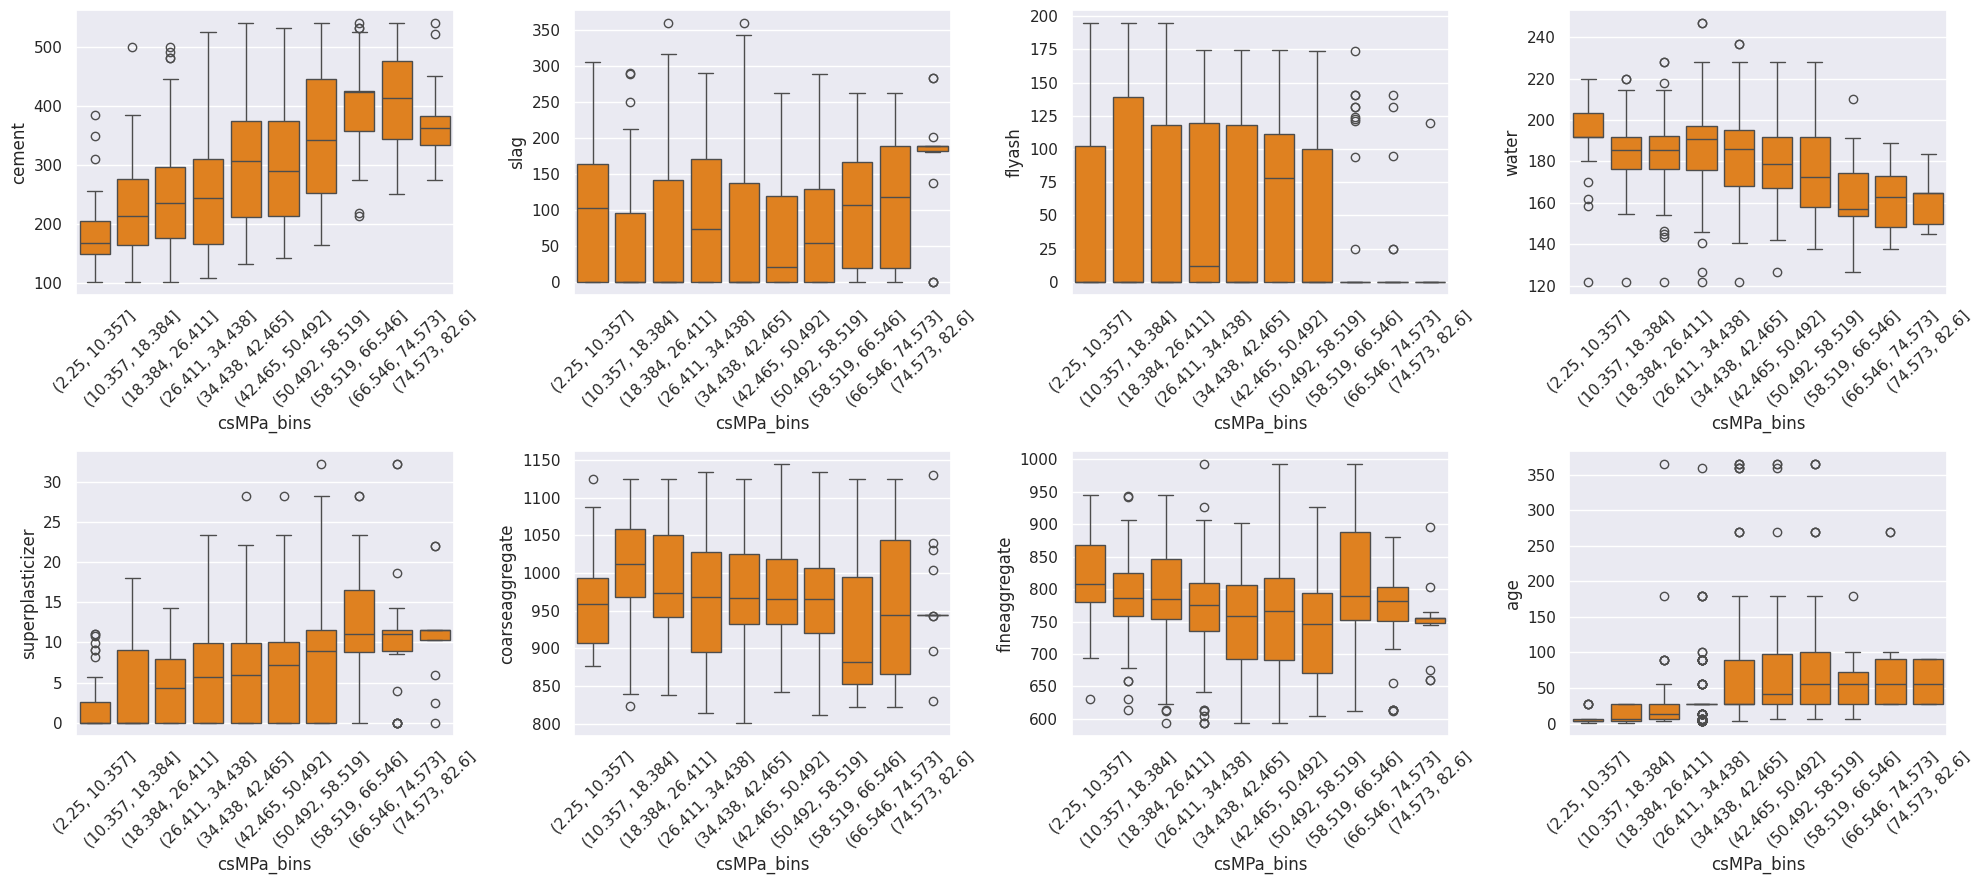

In [22]:
grid = GridSpec(2, 4) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

# Definindo a paleta de cores
color_palette = ['#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

aux = df4.copy()

# Dividindo os dados em 5 bins
aux['csMPa_bins'] = pd.cut(df4['csMPa'], bins = 10)

#cement
plt.subplot(grid[0, 0])
sns.boxplot(x = 'csMPa_bins', y = 'cement', data = aux)
plt.xticks(rotation = 45)

#slag
plt.subplot(grid[0, 1])
sns.boxplot(x = 'csMPa_bins', y = 'slag', data = aux)
plt.xticks(rotation = 45)

#flyash
plt.subplot(grid[0, 2])
sns.boxplot(x = 'csMPa_bins', y = 'flyash', data = aux)
plt.xticks(rotation = 45)

#water
plt.subplot(grid[0, 3])
sns.boxplot(x = 'csMPa_bins', y = 'water', data = aux)
plt.xticks(rotation = 45)

#superplasticizer
plt.subplot(grid[1, 0])
sns.boxplot(x = 'csMPa_bins', y = 'superplasticizer', data = aux)
plt.xticks(rotation = 45)

#coarseaggregate
plt.subplot(grid[1, 1])
sns.boxplot(x = 'csMPa_bins', y = 'coarseaggregate', data = aux)
plt.xticks(rotation = 45)

#fineaggregate
plt.subplot(grid[1, 2])
sns.boxplot(x = 'csMPa_bins', y = 'fineaggregate', data = aux)
plt.xticks(rotation = 45)

#age
plt.subplot(grid[1, 3])
sns.boxplot(x = 'csMPa_bins', y = 'age', data = aux)
plt.xticks(rotation = 45)

plt.tight_layout();

* O gráfico de Boxplot compara a variável resposta com as demais variáveis independentes, ajudando a visualizar como os quartis da variável alvo variam em relação aos quartis das outras variáveis. Essa análise é útil para identificar variabilidades entre as variáveis. No entanto, observa-se que as variáveis 'flyash' e 'fineaggregate' possuem pouca variabilidade em relação à variável resposta. Isso sugere que essas variáveis podem não contribuir de maneira significativa para o aprendizado do modelo, pois sua influência na variável resposta é limitada.

### 4.3 Análise multivariada

In [23]:
df4.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
995,158.6,148.9,116.0,175.1,15.0,953.3,719.7,28,27.68
507,424.0,22.0,132.0,178.0,8.5,822.0,750.0,28,62.05
334,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,3,23.80
848,252.0,97.0,76.0,194.0,8.0,835.0,821.0,28,33.40
294,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,3,7.40


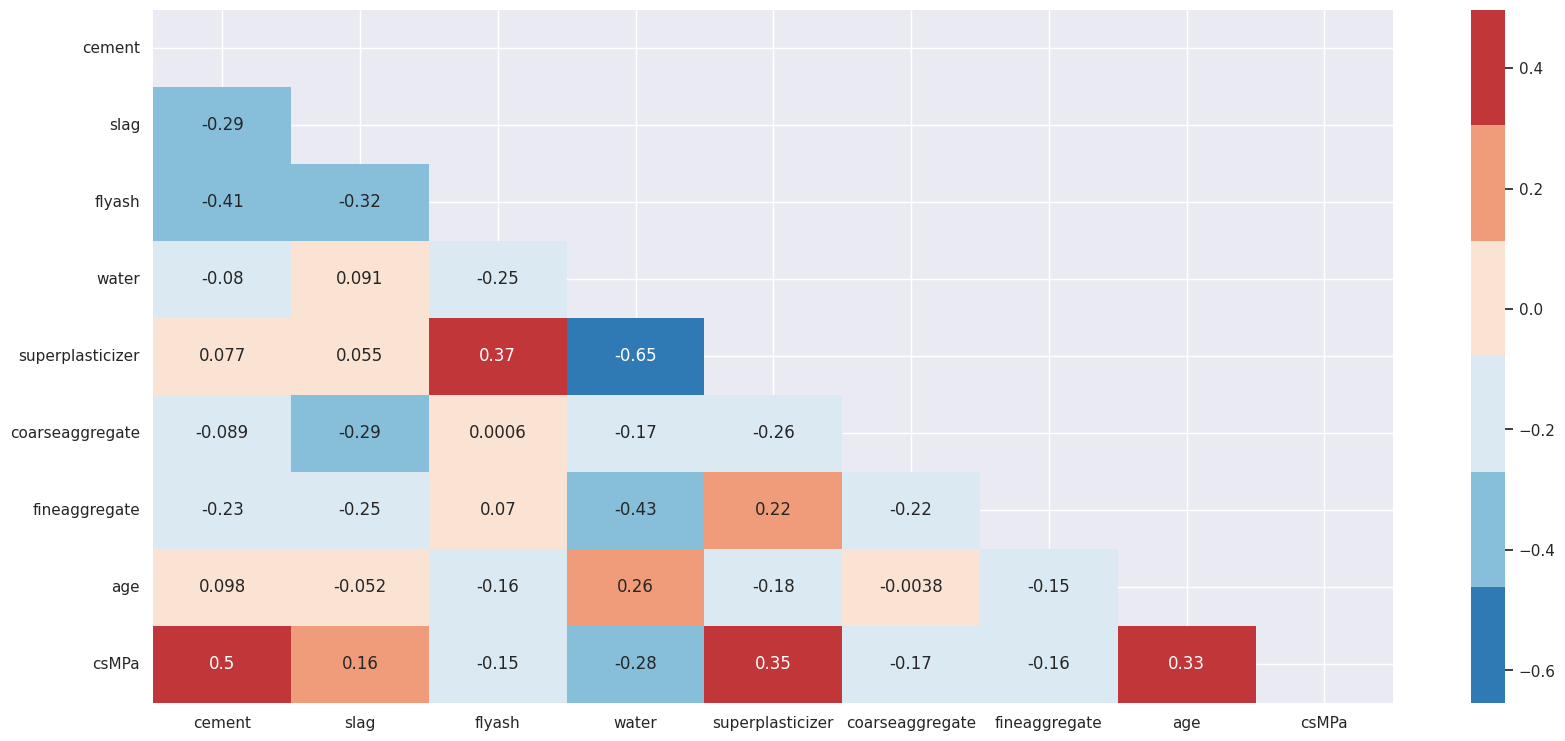

In [24]:
correlation = df4.corr(method = 'pearson')
mask = np.triu(np.ones_like(correlation))
cmap = sns.color_palette('RdBu_r')
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, cmap = cmap, mask = mask, annot = True);

* Um gráfico de heatmap de correlações é como uma tabela de cores que mostra como as diferentes variáveis em seus dados estão relacionadas entre si. Cada quadrado na tabela representa a relação entre duas variáveis. A cor desse quadrado indica o quanto essas variáveis estão relacionadas: cores mais claras significam uma relação mais forte, enquanto cores mais escuras indicam uma relação mais fraca. Esses gráficos são úteis para entender as conexões entre diferentes partes dos seus dados de uma só vez, facilitando a identificação de padrões e relações importantes.
* É importante notar que busca-se uma forte relação entre as variáveis independentes e a variável dependente. Por outro lado, é desejável que haja uma baixa relação entre as variáveis independentes, a fim de evitar a multicolinearidade.

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [25]:
df5 = df4.copy()

### 5.1 Normalização

#### 5.1.1 Dados de treino

In [26]:
df5.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
995,158.6,148.9,116.0,175.1,15.0,953.3,719.7,28,27.68
507,424.0,22.0,132.0,178.0,8.5,822.0,750.0,28,62.05
334,275.1,0.0,121.4,159.5,9.9,1053.6,777.5,3,23.80
848,252.0,97.0,76.0,194.0,8.0,835.0,821.0,28,33.40
294,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,3,7.40


In [27]:
pwd

'/home/leonardo/projetos_/qualidade_concreto/notebooks'

In [28]:
#MinMax Scaler
#cement
mms_cement = pp.MinMaxScaler()
df5['cement'] = mms_cement.fit_transform(df5[['cement']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_cement, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/cement_mms.pkl', 'wb'))

#slag
mms_slag = pp.MinMaxScaler()
df5['slag'] = mms_slag.fit_transform(df5[['slag']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_slag, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/slag_mms.pkl', 'wb'))

#flyash
mms_flyash = pp.MinMaxScaler()
df5['flyash'] = mms_flyash.fit_transform(df5[['flyash']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_flyash, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/flyash_mms.pkl', 'wb'))

#water
mms_water = pp.MinMaxScaler()
df5['water'] = mms_water.fit_transform(df5[['water']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_water, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/water_mms.pkl', 'wb'))

#superplasticizer
mms_superplasticizer = pp.MinMaxScaler()
df5['superplasticizer'] = mms_superplasticizer.fit_transform(df5[['superplasticizer']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_superplasticizer, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/superplasticizer_mms.pkl', 'wb'))

#coarseaggregate
mms_coarseaggregate = pp.MinMaxScaler()
df5['coarseaggregate'] = mms_coarseaggregate.fit_transform(df5[['coarseaggregate']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_coarseaggregate, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/coarseaggregate_mms.pkl', 'wb'))

#fineaggregate
mms_fineaggregate = pp.MinMaxScaler()
df5['fineaggregate'] = mms_fineaggregate.fit_transform(df5[['fineaggregate']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_fineaggregate, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/fineaggregate_mms.pkl', 'wb'))

#age
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)

#Salvando a transformação em Pickle
pickle.dump(mms_age, open('/home/leonardo/projetos_/qualidade_concreto/transformacoes/age_mms.pkl', 'wb'))

* Decidiu-se por utilizar o método MinMaxScaler nas variáveis preditoras, uma vez que seus valores variam entre 0 e 1.

In [29]:
#csMPa
df5['csMPa'] = np.log1p(df5['csMPa'])

* Optou-se por aplicar a transformação logaritima na variável resposta, pois também foi identificada na análise exploratória dos dados não possuia uma distribuição normal.

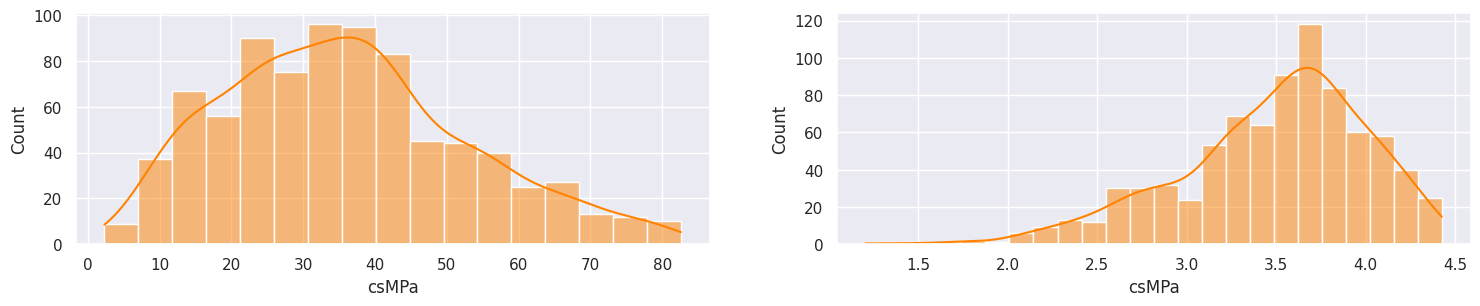

In [30]:
plt.figure(figsize = (18, 3)) #Ajuste o tamanho conforme necessário

#csMPa
plt.subplot(1, 2, 1)
sns.histplot(x = 'csMPa', data = df4, kde = True)

plt.subplot(1, 2, 2)
sns.histplot(x = 'csMPa', data = df5, kde = True);

In [31]:
df5.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
995,0.129224,0.414302,0.594872,0.425719,0.465839,0.442733,0.315354,0.074176,3.356200
507,0.735160,0.061213,0.676923,0.448882,0.263975,0.061047,0.391370,0.074176,4.143928
334,0.395205,0.000000,0.622564,0.301118,0.307453,0.734302,0.460361,0.005495,3.210844
848,0.342466,0.269894,0.389744,0.576677,0.248447,0.098837,0.569493,0.074176,3.538057
294,0.152740,0.117418,0.637436,0.291534,0.335404,0.813372,0.507275,0.005495,2.128232


#### 5.1.2 Dados de teste

In [32]:
dados_orig = pd.concat([x_teste, y_teste], axis = 1)

In [33]:
x_teste.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7
136,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3
918,145.0,0.0,179.0,202.0,8.0,824.0,869.0,28


In [34]:
#cement
x_teste['cement'] = mms_cement.transform(x_teste[['cement']].values) 

#slag
x_teste['slag'] = mms_slag.transform(x_teste[['slag']].values) 

#flyash
x_teste['flyash'] = mms_flyash.transform(x_teste[['flyash']].values) 

#water
x_teste['water'] = mms_water.transform(x_teste[['water']].values) 

#superplasticizer
x_teste['superplasticizer'] = mms_superplasticizer.transform(x_teste[['superplasticizer']].values) 

#coarseaggregate
x_teste['coarseaggregate'] = mms_coarseaggregate.transform(x_teste[['coarseaggregate']].values) 

#fineaggregate
x_teste['fineaggregate'] = mms_fineaggregate.transform(x_teste[['fineaggregate']].values) 

#age
x_teste['age'] = mms_age.transform(x_teste[['age']].values)

y_teste = np.array(y_teste).reshape(-1, 1)

In [35]:
#csMPa
y_teste = np.log1p(y_teste)

In [36]:
dados_orig.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365,52.91
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
136,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28,74.50
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
918,145.0,0.0,179.0,202.0,8.0,824.0,869.0,28,10.54


In [37]:
x_teste.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
31,0.374429,0.317195,0.000000,0.848243,0.000000,0.380814,0.190667,1.000000
109,0.594977,0.525876,0.000000,0.344249,0.360248,0.417733,0.405921,0.016484
136,0.657306,0.525876,0.000000,0.192492,0.683230,0.417733,0.405921,0.074176
88,0.594977,0.525876,0.000000,0.344249,0.360248,0.417733,0.405921,0.005495
918,0.098174,0.000000,0.917949,0.640575,0.248447,0.066860,0.689915,0.074176


# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [38]:
df6 = df5.copy()

### 6.1 Selecionar as variáveis mais relevantes

#### 6.1.2 Importância das árvores

In [39]:
df6.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
995,0.129224,0.414302,0.594872,0.425719,0.465839,0.442733,0.315354,0.074176,3.356200
507,0.735160,0.061213,0.676923,0.448882,0.263975,0.061047,0.391370,0.074176,4.143928
334,0.395205,0.000000,0.622564,0.301118,0.307453,0.734302,0.460361,0.005495,3.210844
848,0.342466,0.269894,0.389744,0.576677,0.248447,0.098837,0.569493,0.074176,3.538057
294,0.152740,0.117418,0.637436,0.291534,0.335404,0.813372,0.507275,0.005495,2.128232


In [40]:
#Definição do modelo
forest = RandomForestRegressor(n_estimators = 200, random_state = 0, n_jobs = -1)

#Preparação dos dados
x_treino_n = df6.drop(['csMPa'], axis = 1)
y_treino_n = df6['csMPa'].values
forest.fit(x_treino_n, y_treino_n)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)

Rank das importâncias:
           Variavel  Importancia
0               age     0.379739
0            cement     0.335083
0             water     0.079706
0              slag     0.071161
0  superplasticizer     0.043000
0     fineaggregate     0.039383
0   coarseaggregate     0.033449
0            flyash     0.018478


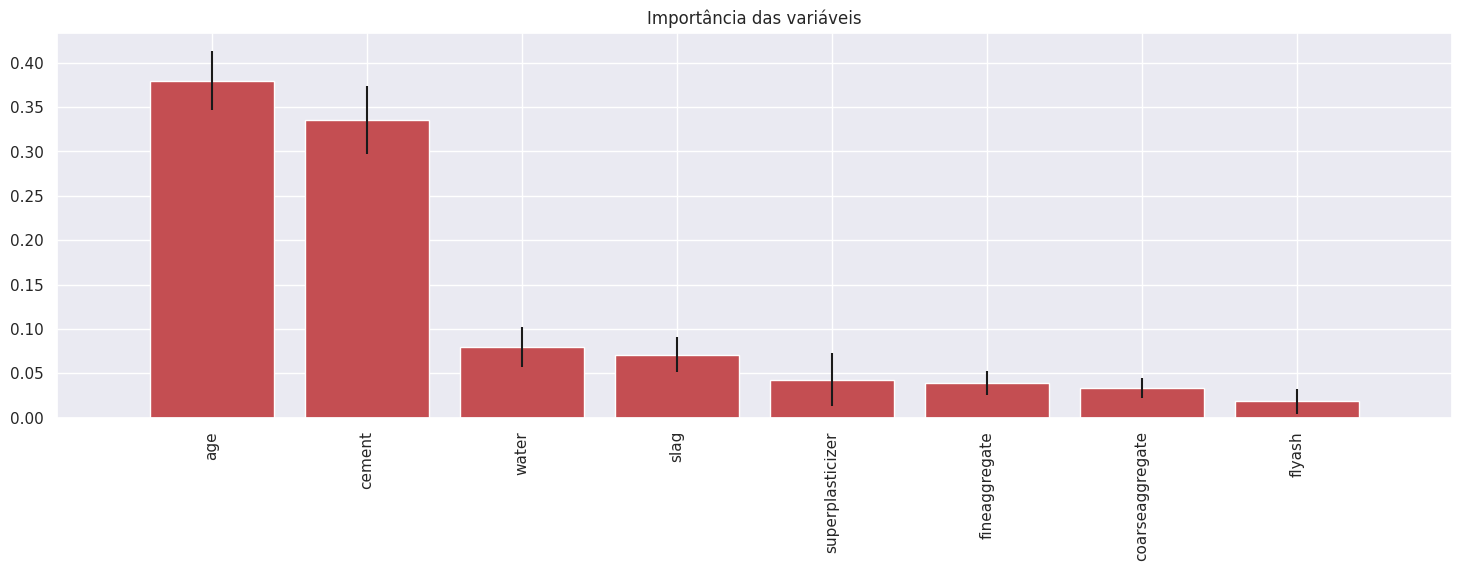

In [41]:
importancias = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importancias)[::-1]

# Imprimindo o rank das importâncias
print('Rank das importâncias:')
df = pd.DataFrame()
for i, j in zip(x_treino_n, forest.feature_importances_):
    aux = pd.DataFrame({'Variavel': i, 'Importancia': j}, index = [0])
    df = pd.concat([df, aux], axis = 0)

print(df.sort_values('Importancia', ascending = False))

# Plotando a impureza baseando-se na importância das variáveis
plt.figure(figsize = (18, 5))
plt.title('Importância das variáveis')

# Barra do gráfico com as importâncias
plt.bar(range(x_treino_n.shape[1]), importancias[indices], color ='r', yerr = std[indices], align = 'center')

# Definindo os rótulos do eixo x como os nomes das colunas
plt.xticks(range(x_treino_n.shape[1]), x_treino_n.columns[indices], rotation = 90)

plt.xlim([-1, x_treino_n.shape[1]])
plt.show();

* A importância das árvores serve para analisar e visualizar a relevância das variáveis preditoras em um modelo de floresta aleatória. O atributo feature_importances_ é usado em modelos de árvores de decisão e florestas aleatórias para fornecer uma medida da importância de cada variável preditora no modelo. Esse atributo atribui uma pontuação de importância para cada variável com base em sua contribuição para reduzir a impureza nos nós da árvore durante o treinamento do modelo. Neste caso, as variáveis 'age' e 'cement' possuem maior relevância em relação as outras variáveis. 

# 7. (Algoritmos de Ml) Passo 7: Implementar os modelos de machine learning

In [42]:
df7 = df6.copy()

In [43]:
df7.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

In [44]:
#colunas_selecionadas = ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']
colunas_selecionadas = ['cement', 'age']

x_treino = df7[colunas_selecionadas]
y_treino = df7['csMPa']

In [45]:
x_teste = x_teste[colunas_selecionadas]

In [46]:
x_treino.head()

,cement,age
995,0.129224,0.074176
507,0.735160,0.074176
334,0.395205,0.005495
848,0.342466,0.074176
294,0.152740,0.005495


In [47]:
x_teste.head()

,cement,age
31,0.374429,1.000000
109,0.594977,0.016484
136,0.657306,0.074176
88,0.594977,0.005495
918,0.098174,0.074176


### 7.1 Algoritmo de Média (Baseline)

In [48]:
aux1 = x_treino.copy()
aux1['csMPa'] = y_treino.copy()

#Previsão
aux2 = aux1[['cement', 'csMPa']].groupby('cement').mean().reset_index().rename(columns = {'csMPa': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left',  on = 'cement')
y_pred_media = aux1['predictions']

#Resultado
resultado_media = ml_error(np.expm1(y_treino), np.expm1(y_pred_media.values), desvpad = False)
resultado_media = pd.DataFrame({'algoritmo': ['DummyRegressor'],
                                      'mae_cv': resultado_media['mae'],
                                      'mape_cv': resultado_media['mape'],
                                      'rmse_cv': resultado_media['rmse']}, index = [0])
resultado_media

,algoritmo,mae_cv,mape_cv,rmse_cv
0,DummyRegressor,8.56,0.32,11.03


* Um modelo baseline é importante no processo de modelagem em machine learning, pois fornece uma base para avaliar e comparar o desempenho de outros modelos mais avançados. Ele ajuda a determinar se os modelos mais complexos estão fornecendo benefícios significativos em termos de precisão das previsões e identificar possíveis problemas de modelagem.

### 7.2 Algoritmo Regressão linear

In [49]:
#Definindo o modelo
lr_modelo = lm.LinearRegression()

#Treinando o modelo com cross validation
y_pred_lr = validacao_cruzada(lr_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_lr

,algoritmo,mae_cv,mape_cv,rmse_cv
0,LinearRegression,11.96,0.42,15.49


### 7.3 Algoritmo Regressão linear Lasso

In [50]:
#Definindo o modelo
lrr_modelo = Lasso(alpha = 0.01)

#Treinando o modelo com cross validation
y_pred_lrr = validacao_cruzada(lrr_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_lrr

,algoritmo,mae_cv,mape_cv,rmse_cv
0,Lasso,11.59,0.43,14.65


### 7.4 Algoritmo Regressão linear Ridge

In [51]:
#Definindo o modelo
lrd_modelo = Ridge(alpha = 0.01)

#Treinando o modelo com cross validation
y_pred_lrd = validacao_cruzada(lrd_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_lrd

,algoritmo,mae_cv,mape_cv,rmse_cv
0,Ridge,11.96,0.42,15.49


### 7.5 Algoritmo Extra trees

In [52]:
#Definindo o modelo
et_modelo = ExtraTreesRegressor(n_estimators = 100)

#Treinando o modelo com cross validation
y_pred_et = validacao_cruzada(et_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_et

,algoritmo,mae_cv,mape_cv,rmse_cv
0,ExtraTreesRegressor,7.42,0.25,10.30


### 7.6 Algoritmo GradientBoostingRegressor

In [53]:
#Definindo o modelo
gbr_modelo = gbr()

#Treinando o modelo com cross validation
y_pred_gbr = validacao_cruzada(gbr_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_gbr

,algoritmo,mae_cv,mape_cv,rmse_cv
0,GradientBoostingRegressor,6.74,0.22,8.74


### 7.7 Algoritmo SVR

In [54]:
#Definindo o modelo
svr_modelo = SVR(kernel = 'rbf', C = 1.0, epsilon = 0.1)

#Treinando o modelo com cross validation
y_pred_svr = validacao_cruzada(svr_modelo, x_treino, y_treino, desvpad = False, verbose = False)

#Resultado
y_pred_svr

,algoritmo,mae_cv,mape_cv,rmse_cv
0,SVR,8.36,0.29,10.72


### 7.8 Performance dos modelos

In [55]:
resultado = pd.concat([resultado_media, y_pred_lr, y_pred_lrr, y_pred_lrd, y_pred_et, y_pred_gbr, y_pred_svr], ignore_index = True)
resultado.sort_values('rmse_cv', ascending = False)

,algoritmo,mae_cv,mape_cv,rmse_cv
5,GradientBoostingRegressor,6.74,0.22,8.74
1,LinearRegression,11.96,0.42,15.49
3,Ridge,11.96,0.42,15.49
2,Lasso,11.59,0.43,14.65
0,DummyRegressor,8.56,0.32,11.03
6,SVR,8.36,0.29,10.72
4,ExtraTreesRegressor,7.42,0.25,10.30


* O modelo GradientBoostingRegressor teve o melhor desempenho em relação aos demais modelos testados.

# 8. (Algoritmos de Ml) Passo 8: Ajuste dos hiperparâmetros no algoritmo

### 8.1 <s>Bayesian search CV</s>

In [56]:
#Encontrando os melhores parâmetros 
#parametros = {'alpha': [0.0001, 0.001],
#              'tol': [0.0001, 0.001]}

In [57]:
# Instanciando o objeto GridSearchCV
#bayesian_search = BayesSearchCV(estimator = Ridge(),
#                                search_spaces = parametros,
#                                n_iter = 50,
#                                random_state = 42,
#                                n_jobs = -1,
#                                cv = 5)

# Treinando o modelo com a otimização
#bayesian_search.fit(x_treino, y_treino)

# Obtendo os melhores hiperparâmetros
#melhores_parametros = bayesian_search.best_params_

In [58]:
#melhores_parametros

### 8.1 Grid search CV

In [59]:
parametros = {'n_estimators': [200, 500],
              'learning_rate': [0.01, 0.1],
              'max_depth': [4, 6],
              'min_samples_split': [2, 5, 9]}

In [60]:
# Função para calcular RMSE
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

# Criando o scorer
rmse_scorer = make_scorer(rmse, greater_is_better = False)

# Definindo o modelo
gbr_modelo = gbr()

# Instanciando o objeto GridSearchCV
grid_search = GridSearchCV(estimator = gbr_modelo,
                           param_grid = parametros,
                           scoring = rmse_scorer,
                           n_jobs = -1,
                           cv = 5,
                           verbose = 1)

# Treinando o modelo com a otimização
grid_search.fit(x_treino.values, y_treino.values)

# Obtendo os melhores hiperparâmetros
melhores_parametros = grid_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 6],
                         'min_samples_split': [2, 5, 9],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=1)

In [61]:
melhores_parametros

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

* Foi realizado um processo de varredura dos hiperparâmetros do modelo de machine learning selecionado para determinar os melhores valores para cada um. O método utilizado para essa otimização foi o GridSearchCV, considerando a escassez de dados disponíveis.

### 8.2 Treinar modelo escolhido com os melhores parâmetros

In [62]:
#Definindo o modelo
gbr_modelo = gbr(**melhores_parametros)

#Treinando o modelo com cross validation
gbr_modelo.fit(x_treino, y_treino)

#Salvando o modelo treinado em Pickle
pickle.dump(gbr_modelo, open('/home/leonardo/projetos_/qualidade_concreto/modelo/modelo_treinado.pkl', 'wb'))

#Predição do modelo
y_pred_gbr = gbr_modelo.predict(x_teste)

aux = pd.DataFrame({'algoritmo': 'GradientBoostingRegressor'}, index = [0])

#Treinando o modelo com cross validation
resultado = pd.concat([aux, ml_error(np.expm1(y_teste), np.expm1(y_pred_gbr), desvpad = False)], axis = 1)

#Resultado
resultado

GradientBoostingRegressor(max_depth=4, min_samples_split=5, n_estimators=200)

,algoritmo,mae,mape,rmse
0,GradientBoostingRegressor,5.80,0.69,7.73


# 9. (Avaliação do algoritmo) Passo 9: Performance do negócio ROI

**MAE:** (Erro Absoluto Médio) calcula a média da diferença absoluta entre os valores previstos (y_pred) e os valores reais (y).  
É interpretado como a média das magnitudes dos erros de previsão.  
**Exemplo:** Em média, suas previsões estão a (x) unidades de distância do valor real. Ou seja, seus modelos estão subestimando ou superestimando o valor real em uma média de (x) unidades.
    
**MAPE:** (Erro Absoluto Percentual Médio) calcula a média dos erros absolutos relativos (porcentagem).  
É interpretado como a média percentual dos erros de previsão em relação aos valores reais.  
**Exemplo:** Em média, suas previsões estão erradas em (x %) em relação ao valor real. Isso significa que, em média, seus modelos estão prevendo valores que são (x %) maiores ou menores que o valor real.

In [63]:
# Dados inseridos manualmente
#dados_manuais = np.array([[49.00,236.00,0.00,176.00,13.00,847.00,893.00,28]])
dados_manuais = np.array([[323.7, 183.8]])

# Fazer a previsão com os dados inseridos manualmente
y_pred = gbr_modelo.predict(dados_manuais)

# Imprimir a previsão
print("Predição:", np.expm1(y_pred))

Predição: [71.46942886]


In [64]:
dados_orig['prediction'] = np.expm1(y_pred_gbr)
dados_orig['prediction'] = dados_orig['prediction'].round(2)
pd.options.display.float_format = '{:.2f}'.format

In [65]:
dados_orig.drop(columns = 'csMPa', axis = 1).head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,prediction
31,266.00,114.00,0.00,228.00,0.00,932.00,670.00,365,47.45
109,362.60,189.00,0.00,164.90,11.60,944.70,755.80,7,38.28
136,389.90,189.00,0.00,145.90,22.00,944.70,755.80,28,60.72
88,362.60,189.00,0.00,164.90,11.60,944.70,755.80,3,31.90
918,145.00,0.00,179.00,202.00,8.00,824.00,869.00,28,20.12


In [66]:
dados_orig_cost = pd.DataFrame()

dados_orig_cost['cement_cost'] = dados_orig['cement'] * 12
dados_orig_cost['slag_cost'] = dados_orig['slag'] * 15
dados_orig_cost['flyash_cost'] = dados_orig['flyash'] * 8
dados_orig_cost['water_cost'] = dados_orig['water'] * 5
dados_orig_cost['superplasticizer_cost'] = dados_orig['superplasticizer'] * 18
dados_orig_cost['coarseaggregate_cost'] = dados_orig['coarseaggregate'] * 12
dados_orig_cost['fineaggregate_cost'] = dados_orig['fineaggregate'] * 13
dados_orig_cost['age_cost'] = dados_orig['age'] * 5
dados_orig_cost['total_cost'] = dados_orig_cost.sum(axis = 1)
dados_orig_cost['prediction'] = dados_orig['prediction']

In [67]:
dados_orig_cost.head()

,cement_cost,slag_cost,flyash_cost,water_cost,superplasticizer_cost,coarseaggregate_cost,fineaggregate_cost,age_cost,total_cost,prediction
31,3192.00,1710.00,0.00,1140.00,0.00,11184.00,8710.00,1825,27761.00,47.45
109,4351.20,2835.00,0.00,824.50,208.80,11336.40,9825.40,35,29416.30,38.28
136,4678.80,2835.00,0.00,729.50,396.00,11336.40,9825.40,140,29941.10,60.72
88,4351.20,2835.00,0.00,824.50,208.80,11336.40,9825.40,15,29396.30,31.90
918,1740.00,0.00,1432.00,1010.00,144.00,9888.00,11297.00,140,25651.00,20.12


In [68]:
# Calcular o maior
maior_valor = dados_orig_cost['prediction'].max()

# Criar os bins
bins = list(np.arange(0, maior_valor + 1, 10))

# Definir os rótulos das faixas
labels = [f'{i:.2f}-{i+9.99:.2f}' for i in range(0, int(maior_valor), 10)]

# Criar uma nova coluna com as faixas
dados_orig_cost['intervalos_prediction'] = pd.cut(dados_orig_cost['prediction'], bins = bins, labels = labels)

dados_orig_cost[['intervalos_prediction', 'total_cost']].groupby('intervalos_prediction').sum().reset_index()

,intervalos_prediction,total_cost
0,0.00-9.99,110173.40
1,10.00-19.99,964716.50
2,20.00-29.99,929422.10
3,30.00-39.99,1729035.60
4,40.00-49.99,1431414.90
5,50.00-59.99,311085.60
6,60.00-69.99,233061.70


In [69]:
#intervalos_70_79_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '70.00-79.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
#intervalos_70_79 = pd.concat([intervalos_70_79_aux.iloc[0, :], intervalos_70_79_aux.iloc[-1, :]], axis = 1).T
#intervalos_70_79['variacao_%'] = 1 - (intervalos_70_79['total_cost'].min() / intervalos_70_79['total_cost'].max())

intervalos_60_69_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '60.00-69.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_60_69 = pd.concat([intervalos_60_69_aux.iloc[0, :], intervalos_60_69_aux.iloc[-1, :]], axis = 1).T
intervalos_60_69['variacao_%'] = 1 - (intervalos_60_69['total_cost'].min() / intervalos_60_69['total_cost'].max())

intervalos_50_59_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '50.00-59.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_50_59 = pd.concat([intervalos_50_59_aux.iloc[0, :], intervalos_50_59_aux.iloc[-1, :]], axis = 1).T
intervalos_50_59['variacao_%'] = 1 - (intervalos_50_59['total_cost'].min() / intervalos_50_59['total_cost'].max())

intervalos_40_49_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '40.00-49.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_40_49 = pd.concat([intervalos_40_49_aux.iloc[0, :], intervalos_40_49_aux.iloc[-1, :]], axis = 1).T
intervalos_40_49['variacao_%'] = 1 - (intervalos_40_49['total_cost'].min() / intervalos_40_49['total_cost'].max())

intervalos_30_39_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '30.00-39.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_30_39 = pd.concat([intervalos_30_39_aux.iloc[0, :], intervalos_30_39_aux.iloc[-1, :]], axis = 1).T
intervalos_30_39['variacao_%'] = 1 - (intervalos_30_39['total_cost'].min() / intervalos_30_39['total_cost'].max())

intervalos_20_29_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '20.00-29.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_20_29 = pd.concat([intervalos_20_29_aux.iloc[0, :], intervalos_20_29_aux.iloc[-1, :]], axis = 1).T
intervalos_20_29['variacao_%'] = 1 - (intervalos_20_29['total_cost'].min() / intervalos_20_29['total_cost'].max())

intervalos_10_19_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '10.00-19.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_10_19 = pd.concat([intervalos_10_19_aux.iloc[0, :], intervalos_10_19_aux.iloc[-1, :]], axis = 1).T
intervalos_10_19['variacao_%'] = 1 - (intervalos_10_19['total_cost'].min() / intervalos_10_19['total_cost'].max())

intervalos_0_9_aux = dados_orig_cost.loc[dados_orig_cost['intervalos_prediction'] == '0.00-9.99', ['intervalos_prediction', 'total_cost']].sort_values('total_cost', ascending = True)
intervalos_0_9 = pd.concat([intervalos_0_9_aux.iloc[0, :], intervalos_0_9_aux.iloc[-1, :]], axis = 1).T
intervalos_0_9['variacao_%'] = 1 - (intervalos_0_9['total_cost'].min() / intervalos_0_9['total_cost'].max())

In [83]:
resultado = pd.concat([intervalos_0_9, intervalos_10_19, intervalos_20_29, intervalos_30_39, intervalos_40_49, intervalos_50_59, intervalos_60_69], axis = 0)

In [84]:
resultado.reset_index(drop = True)

,intervalos_prediction,total_cost,variacao_%
0,0.00-9.99,27300.20,0.02
1,0.00-9.99,27789.50,0.02
2,10.00-19.99,25906.00,0.11
3,10.00-19.99,29112.10,0.11
4,20.00-29.99,25651.00,0.14
5,20.00-29.99,29912.50,0.14
6,30.00-39.99,25639.00,0.14
7,30.00-39.99,29821.30,0.14
8,40.00-49.99,26035.00,0.15
9,40.00-49.99,30629.90,0.15


# 10. (Modelo em produção) Passo 10 Modelo em produção

### 10.1 Classe do projeto (salvar como script.py)

In [72]:
import pickle
import pandas                                  as pd
import numpy                                   as np

class Projeto:
    def __init__(self):
        self.home_path = '/home/leonardo/projetos_/qualidade_concreto/transformacoes'
        self.age_mms = pickle.load(open(self.home_path + 'age_mms.pkl', 'rb'))
        self.cement_mms = pickle.load(open(self.home_path + 'cement_mms.pkl', 'rb'))
        self.coarseaggregate_mms = pickle.load(open(self.home_path + 'coarseaggregate_mms.pkl', 'rb'))
        self.fineaggregate_mms = pickle.load(open(self.home_path + 'fineaggregate_mms.pkl', 'rb'))
        self.flyash_mms = pickle.load(open(self.home_path + 'flyash_mms.pkl', 'rb'))
        self.slag_mms = pickle.load(open(self.home_path + 'slag_mms.pkl', 'rb'))
        self.superplasticizer_mms = pickle.load(open(self.home_path + 'superplasticizer_mms.pkl', 'rb'))
        self.water_mms = pickle.load(open(self.home_path + 'water_mms.pkl', 'rb'))

    def transformacao_dos_dados(self, df5):
        df5['age'] = self.age_mms.transform(df5[['age']].values)
        df5['cement'] = self.cement_mms.transform(df5[['cement']].values)
        df5['coarseaggregate'] = self.coarseaggregate_mms.transform(df5[['coarseaggregate']].values)
        df5['fineaggregate'] = self.fineaggregate_mms.transform(df5[['fineaggregate']].values)
        df5['flyash'] = self.flyash_mms.transform(df5[['flyash']].values)
        df5['slag'] = self.slag_mms.transform(df5[['slag']].values)
        df5['superplasticizer'] = self.superplasticizer_mms.transform(df5[['superplasticizer']].values)
        df5['water'] = self.water_mms.transform(df5[['water']].values)

        #Colunas selecionadas a partir a importância das variáveis
        colunas_selecionadas = ['cement', 'age']
        return df5[colunas_selecionadas]

    def get_prediction(self, modelo, dados_original, dados_teste):
        pred = modelo.predict(dados_teste)
        dados_original['Score'] = pred[:, 1].tolist()
        return dados_original.to_json(orient = 'records', date_format = 'iso')

### 10.2 Criar API (salvar como handler.py)

In [73]:
import pickle
import pandas as pd
from flask import Flask, request, Response

#Diretório onde está salvo a API handler.py
#Nome do arquivo.py
#Nome da classe que foi criada dentro do arquivo.py

#from Diretório.arquivo        import classe
from script import Projeto

# Carregando o modelo treinado usando pickle
modelo = pickle.load(open('/home/leonardo/projetos_/qualidade_concreto/modelo/modelo_treinado.pkl', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods = ['POST'])
def predict():
    teste_json = request.get_json() #Recebe um arquivo JSON a partir da request

    if teste_json:  #Se o teste_json for diferente de vazio, ou seja, se foi carregado algum dado
        #Verifica se o arquivo passado é um tipo de dicionário e se sim, foi enviado um arquivo com somente uma linha
        if isinstance(teste_json, dict):
            #Cria um dataframe e para isso é necessário indicar no Pandas qual é o nº da linha inicial, nesta caso, 0
            dados_originais = pd.DataFrame(teste_json, index = [0])
        else:
            #Se não for é um dicionário, foi enviado um arquivo com mais de uma linha
            dados_originais = pd.DataFrame(teste_json, columns = teste_json[0].keys())

        #Instanciando a classe do projeto
        pipeline = Projeto()

        #Transformação dos dados
        df5 = pipeline.transformacao_dos_dados(dados_originais)
        
        #predição
        df_resposta = pipeline.get_prediction(modelo, dados_originais, df5)
        
        return df_resposta
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    #Dizer para endpoint rodar no localhost (rodando na máquina)
    #port = os.environ.get('PORT', 5000)
    #app.run('0.0.0.0', port = port)
    app.run('0.0.0.0', debug = True)

ModuleNotFoundError: No module named 'script'

### 10.3 Testar a API

In [93]:
import requests

#Carregando os dados para teste
df_teste = df1.copy()

In [94]:
df_teste = df_teste.drop('csMPa', axis = 1).head()
df_teste

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
995,158.60,148.90,116.00,175.10,15.00,953.30,719.70,28
507,424.00,22.00,132.00,178.00,8.50,822.00,750.00,28
334,275.10,0.00,121.40,159.50,9.90,1053.60,777.50,3
848,252.00,97.00,76.00,194.00,8.00,835.00,821.00,28
294,168.90,42.20,124.30,158.30,10.80,1080.80,796.20,3


In [95]:
import json

#Convertendo o dataframe em formato JSON
data_json = json.dumps(df_teste.to_dict(orient = 'records')) 
data_json

'[{"cement": 158.6, "slag": 148.9, "flyash": 116.0, "water": 175.1, "superplasticizer": 15.0, "coarseaggregate": 953.3, "fineaggregate": 719.7, "age": 28}, {"cement": 424.0, "slag": 22.0, "flyash": 132.0, "water": 178.0, "superplasticizer": 8.5, "coarseaggregate": 822.0, "fineaggregate": 750.0, "age": 28}, {"cement": 275.1, "slag": 0.0, "flyash": 121.4, "water": 159.5, "superplasticizer": 9.9, "coarseaggregate": 1053.6, "fineaggregate": 777.5, "age": 3}, {"cement": 252.0, "slag": 97.0, "flyash": 76.0, "water": 194.0, "superplasticizer": 8.0, "coarseaggregate": 835.0, "fineaggregate": 821.0, "age": 28}, {"cement": 168.9, "slag": 42.2, "flyash": 124.3, "water": 158.3, "superplasticizer": 10.8, "coarseaggregate": 1080.8, "fineaggregate": 796.2, "age": 3}]'

### Para colocar a API "de pé", digitar no terminal no nome da API, neste caso, python api_handler.py

In [96]:
#Chamando a API
import json

data_json = json.dumps(df_teste.to_dict(orient = 'records')) #Convertendo o dataframe em formato JSON
#url = 'https://health-insurance-ixwn.onrender.com/predict' #Este é o formato de endereço a de um servidor na nuvem
url = 'http://0.0.0.0:5000/predict' #Endpoint -> 0.0.0.0 é a máquina local e :5000 é a porta padrão da biblioteca flask
header = {'Content-type': 'application/json'} #Indica para o API qual tipo de dado ele está recebendo
r = requests.post(url, data = data_json, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [97]:
pd.DataFrame(r.json(), columns = r.json()[0].keys())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,Score
0,0.13,0.41,0.59,0.43,0.47,0.44,0.32,0.07,3.24
1,0.74,0.06,0.68,0.45,0.26,0.06,0.39,0.07,4.10
2,0.40,0.00,0.62,0.30,0.31,0.73,0.46,0.01,3.00
3,0.34,0.27,0.39,0.58,0.25,0.10,0.57,0.07,3.31
4,0.15,0.12,0.64,0.29,0.34,0.81,0.51,0.01,2.39
